# MediaPipe 작업을 사용한 이미지 분류자

이 노트북은 MediaPipe Tasks Python API를 사용하여 이미지를 분류하는 방법을 보여줍니다.

## 준비

MediaPipe 설치부터 시작해 보겠습니다.

In [1]:
!pip install -U numpy==2.0.2

In [2]:
!pip install -q mediapipe==0.10.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


그런 다음 기성 모델을 다운로드하십시오. 사용할 수 있는 더 많은 이미지 분류 모델을 보려면 [MediaPipe 문서](https://developers.google.com/mediapipe/solutions/vision/image_classifier#models)를 확인하세요.

In [3]:
!wget -O classifier.tflite -q https://storage.googleapis.com/mediapipe-models/image_classifier/efficientnet_lite0/float32/1/efficientnet_lite0.tflite

## 시각화 유틸리티



In [6]:
#@markdown 이미지 분류 결과를 시각화하기 위해 몇 가지 기능을 구현했습니다. <br/> 다음 셀을 실행하여 기능을 활성화하세요.
from matplotlib import pyplot as plt
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(images, predictions):
    """Displays a batch of images with the classifications."""
    # Images and predictions.
    images = [image.numpy_view() for image in images]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display.
    for i, (image, prediction) in enumerate(zip(images[:rows*cols], predictions[:rows*cols])):
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        subplot = display_one_image(image, prediction, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

## 테스트 이미지 다운로드

나중에 사용할 테스트 이미지를 몇 개 가져와 보겠습니다. 이미지([1](https://pixabay.com/photos/hamburger-burger-barbeque-bbq-beef-1238246/), [2](https://pixabay.com/photos/cat-kitten-pets) -animals-housecat-2934720/))는 Pixabay에서 가져온 것입니다.

In [7]:
import urllib

IMAGE_FILENAMES = ['burger.jpg', 'cat.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-tasks/image_classifier/{name}'
  urllib.request.urlretrieve(url, name)

선택적으로 자신의 이미지를 업로드할 수 있습니다. 그렇게 하려면 아래 셀의 주석 처리를 해제하고 실행하십시오.

In [8]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)
# IMAGE_FILENAMES = list(uploaded.keys())

# print('Uploaded files:', IMAGE_FILENAMES)

그럼 이미지를 확인해 볼까요?

burger.jpg


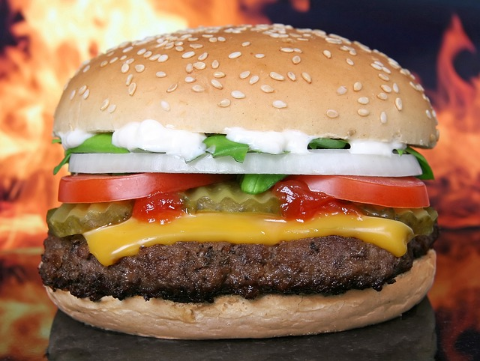

cat.jpg


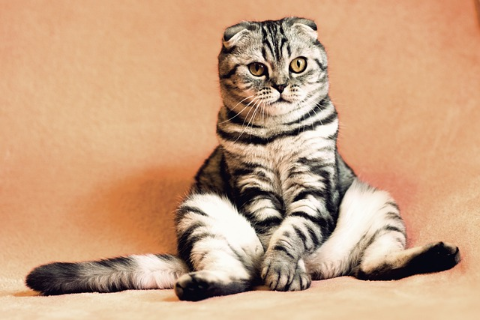

In [9]:
import cv2
from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the images.

images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

## 추론 실행 및 결과 시각화

MediaPipe를 사용하여 이미지 분류를 실행하는 단계는 다음과 같습니다.

이 솔루션이 지원하는 구성 옵션에 대해 자세히 알아보려면 [MediaPipe 문서](https://developers.google.com/mediapipe/solutions/vision/image_classifier/python)를 확인하세요.

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


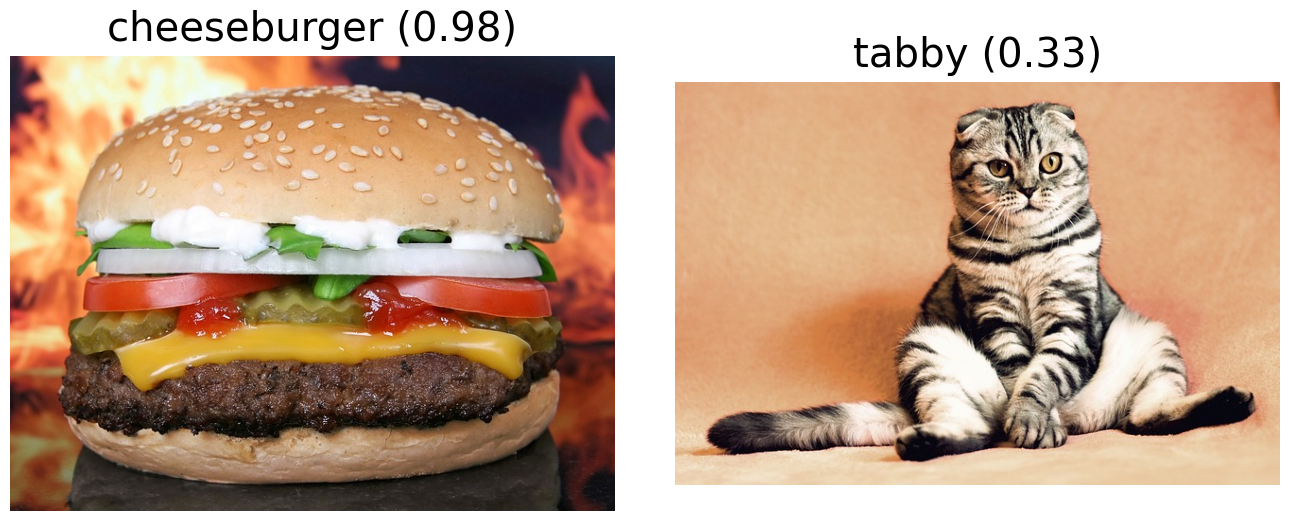

In [10]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python.components import processors
from mediapipe.tasks.python import vision

# STEP 2: Create an ImageClassifier object.
base_options = python.BaseOptions(model_asset_path='classifier.tflite')
options = vision.ImageClassifierOptions(
    base_options=base_options, max_results=4)
classifier = vision.ImageClassifier.create_from_options(options)

images = []
predictions = []
for image_name in IMAGE_FILENAMES:
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_name)

  # STEP 4: Classify the input image.
  classification_result = classifier.classify(image)

  # STEP 5: Process the classification result. In this case, visualize it.
  images.append(image)
  top_category = classification_result.classifications[0].categories[0]
  predictions.append(f"{top_category.category_name} ({top_category.score:.2f})")

display_batch_of_images(images, predictions)